In [1]:
import os
import h5py
import pandas as pd
from scipy.io import loadmat
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
from scipy import signal
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectra
from scipy.stats import f_oneway
from scipy.stats import sem
import math


%matplotlib inline

/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_763/534178414.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [86]:
#os.getcwd()

day = "20181102"
os.system(f"sh ~/Documents/GitHub/Pyhipp_T/get_channels.sh {day}")
# os.system(f"sh ~/Documents/GitHub/Pyhipp test/get_channels.sh {day_dir}")

0

### Use this for obtaining the List of Channels for that date

In [87]:
channel_list = list()
with open("channel_list.txt", "r") as file:
    for line in file.readlines():
        channel_list.append(line.strip())
#os.system("rm channel_list.txt")
print(channel_list)
channel_no = [ch[-3:] for ch in channel_list]

['array01/channel009', 'array01/channel019', 'array01/channel021', 'array01/channel022', 'array01/channel023', 'array01/channel026', 'array01/channel029', 'array01/channel030', 'array01/channel031', 'array02/channel034', 'array02/channel035', 'array02/channel036', 'array02/channel038', 'array02/channel040', 'array02/channel043', 'array02/channel045', 'array02/channel047', 'array02/channel049', 'array02/channel056', 'array03/channel072', 'array03/channel076', 'array03/channel089', 'array03/channel092', 'array03/channel093', 'array04/channel119', 'array04/channel120']


In [2]:
def get_data(day):
    os.system(f"sh ~/Documents/GitHub/Pyhipp_T/get_channels.sh {day}")
    channel_list = list()
    with open("channel_list.txt", "r") as file:
        for line in file.readlines():
            channel_list.append(line.strip())
    #os.system("rm channel_list.txt")
    print(channel_list)
    channel_no = [ch[-3:] for ch in channel_list]
    return channel_list, channel_no


In [122]:
channel_no

['009',
 '019',
 '021',
 '022',
 '023',
 '026',
 '029',
 '030',
 '031',
 '034',
 '035',
 '036',
 '038',
 '040',
 '043',
 '045',
 '047',
 '049',
 '056',
 '072',
 '076',
 '089',
 '092',
 '093',
 '119',
 '120']

In [3]:
channel_list, channel_no = get_data("20181102")

['array01/channel009', 'array01/channel019', 'array01/channel021', 'array01/channel022', 'array01/channel023', 'array01/channel026', 'array01/channel029', 'array01/channel030', 'array01/channel031', 'array02/channel034', 'array02/channel035', 'array02/channel036', 'array02/channel038', 'array02/channel040', 'array02/channel043', 'array02/channel045', 'array02/channel047', 'array02/channel049', 'array02/channel056', 'array03/channel072', 'array03/channel076', 'array03/channel089', 'array03/channel092', 'array03/channel093', 'array04/channel119', 'array04/channel120']


In [88]:
lfp = {}
lfp_list = []
for channel in channel_list:
    temp = loadmat(f"/Volumes/Hippocampus/Data/picasso-misc/{day}/session01/{channel}/rpllfp.mat")
    lfp_list.append(temp.get('df')[0,0][0][0,0][0].flatten())
    lfp[channel] = temp.get('df')[0,0][0][0,0][0].flatten()

print("Number of Channels: ",len(lfp))

Number of Channels:  26


In [89]:
rp_file = h5py.File(f"/Volumes/Hippocampus/Data/picasso-misc/{day}/session01/rplparallel.mat", 'r')
rp = rp_file.get('rp').get('data')
session_start_time = rp.get('session_start_sec')[0,0]
markers = rp.get('markers')
timeStamps = rp.get('timeStamps')
sampling_frequency = 1000

### Segmenting data based on markers
segment_eeg -> each marker as key -> no. of markers -> no. ch -> data segments of each ch

### FOOOF Analysis
- seg_by_ch: 26 channels, each holds all segmented


Helper Functions

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def get_power_spec(epoch, lowcut, highcut, sampling_frequency, nperseg, method='psd'):
    # Apply Butterworth bandpass filter
    b, a = butter_bandpass(lowcut, highcut, sampling_frequency)
    filt_epoch = signal.filtfilt(b, a, epoch)

    if method == 'welch':
        # Compute power spectrum using Welch's method
        freq, xk = signal.welch(filt_epoch, fs=sampling_frequency, nperseg=1000)
    elif method == 'fft':
        fft_result = np.fft.fft(filt_epoch)
        n = len(filt_epoch)  # Number of sample points
        xk = (1/n**2) * np.abs(fft_result) ** 2
        xk = xk[:n//2]  # Keep only positive frequencies
        xk[1:-1] = 2 * xk[1:-1]
        freq = np.fft.fftfreq(n, 1/sampling_frequency)[:n // 2]  # Frequency values for positive frequencies
    else:
        raise ValueError("Invalid method. Choose 'welch' or 'fft'.")

    return freq, xk

def manual_transpose(matrix):
    transposed_matrix = [[None] * len(matrix) for _ in range(len(matrix[0]))]

    # Manually transpose the matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            transposed_matrix[j][i] = matrix[i][j]
    return transposed_matrix

In [9]:
def get_psd_marker_by_ch_singletrial(cue, windowsize=1000, method='fft'):
    cues = [11, 12, 13, 14, 15, 16]
    endcue = [31, 32, 33, 34, 35, 36]
    endcue = endcue[cues.index(cue)]  # pick the corresponding position that the prev trial ended at
    cues.remove(cue)

    annotations = []
    _ts = np.array(timeStamps).flatten()

    for i, m in enumerate(np.array(markers).flatten()):
        annotations.append([int(m), _ts[i]])  # get [[marker, timestamp], ....]

    annotations = sorted(annotations, key=lambda x: x[1])  # sort by ascending timestamps

    selected_annotations = [annotations[i + 1] for i, m in enumerate(annotations) if m[0] == endcue and i + 1 < len(annotations)]  # get the cue onset markers from ending position we want
    del _ts

    selected_segmented_eeg = {}

    for [marker, time] in selected_annotations:
        if marker not in selected_segmented_eeg:
            selected_segmented_eeg[marker] = []
        ts_seg = []  # hold all the seg for the ts
        for channel_data in lfp_list:
            ts_seg.append(channel_data[round(time * 1000):round(time * 1000) + windowsize])
        selected_segmented_eeg[marker].append(ts_seg)

    all_seg = []
    for i in cues:
        all_seg.append(np.transpose(np.array(selected_segmented_eeg[i]), (1, 0, 2)))

    all_psd = []
    for marker_data in all_seg:
        marker_psd = []
        for channel_data in marker_data:  # iterate through all ch for this marker
            power_spec_per_ch = []  # power spec for all segs
            for epoch in channel_data:  # iterate through all segments for this ch
                freq, power_spec = get_power_spec(epoch, 1, 150, sampling_frequency, windowsize, method)
                power_spec_per_ch.append(power_spec)
            marker_psd.append(np.array(power_spec_per_ch))
        all_psd.append(marker_psd)

    return manual_transpose(np.array(all_psd)), freq

In [86]:
# def get_psd_marker_by_ch_singletrial(cue,windowsize=1000):
#     cues = [11,12,13,14,15,16]
#     endcue = [31,32,33,34,35,36]
#     endcue = endcue[cues.index(cue)] # pick the corresponding position that the prev trial ended at
#     cues.remove(cue)

#     annotations = []
#     _ts = np.array(timeStamps).flatten()

#     for i, m in enumerate(np.array(markers).flatten()):
#         annotations.append([int(m), _ts[i]])        # get [[marker, timestamp], ....]

#     annotations = sorted(annotations, key=lambda x: x[1]) # sort by ascending timestamps

#     selected_annotations = [annotations[i+1] for i, m in enumerate(annotations) if m[0] == endcue and i+1 < len(annotations)] # get the cue onset markers from ending position we want
#     del _ts

#     selected_segmented_eeg = {}

#     for [marker, time] in selected_annotations:
#         if marker not in selected_segmented_eeg:
#             selected_segmented_eeg[marker] = []
#         ts_seg = [] # hold all the seg for the ts
#         for channel_data in lfp_list:
#             ts_seg.append(channel_data[round(time*1000):round(time*1000)+windowsize])
#         selected_segmented_eeg[marker].append(ts_seg)

#     all_seg = []
#     # converts from segments by markers to  markers >> segments >> ch
#     for i in cues: 
#         all_seg.append(np.transpose(np.array(selected_segmented_eeg[i]), (1, 0, 2)))

#     all_psd = []
#     for marker_data in all_seg:
#         marker_psd = []
#         for channel_data in marker_data: # iterate through all ch for this marker
#             power_spec_per_ch = [] # power spec for all segs
#             for epoch in channel_data: # iterate through all segments for this ch
#                 freq, power_spec = get_power_spec(epoch, 0.3, 150, sampling_frequency, windowsize)
#                 power_spec_per_ch.append(power_spec)
#             marker_psd.append(np.array(power_spec_per_ch))
#         all_psd.append(marker_psd)
    
#     # power_spec_per_ch = np.array(power_spec_per_ch)
#     # print(power_spec_per_ch.shape, freq.shape)
#     # fg = FOOOFGroup()
#     # fg.fit(freq,power_spec_per_ch,[1,10])
#     # print(fg.get_params('peak_params', 'CF'))
#     return manual_transpose(np.array(all_psd)), freq



In [90]:
all_psd = []
for mk in [11,12,13,14,15,16]:
    psds, freq_fft = get_psd_marker_by_ch_singletrial(mk, method='fft')
    all_psd.append(psds)
all_psd_fft= np.array(all_psd)

/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_56494/2356410638.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return manual_transpose(np.array(all_psd)), freq
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_56494/3037051696.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_psd_fft= np.array(all_psd)


In [14]:
all_psd = []
for mk in [11,12,13,14,15,16]:
    psds, freq_welch = get_psd_marker_by_ch_singletrial(mk, method='welch')
    all_psd.append(psds)
all_psd_welch = np.array(all_psd)

/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_56494/2356410638.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return manual_transpose(np.array(all_psd)), freq
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_56494/2063394354.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_psd_welch = np.array(all_psd)


(2.0, 15.0)

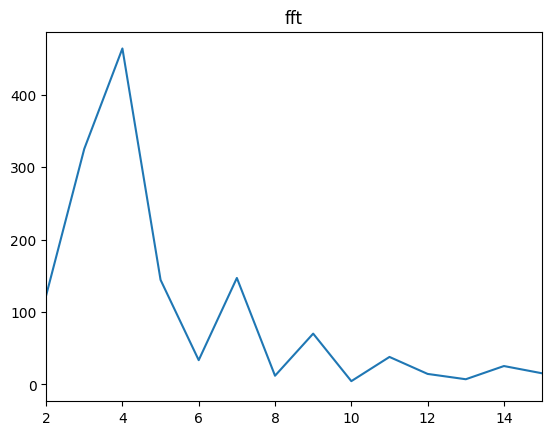

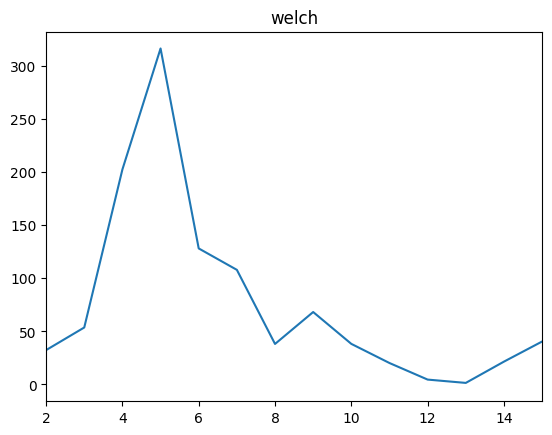

In [19]:
i = 2
plt.title('fft')
plt.plot(freq_fft, all_psd_fft[0][0][0][i])
plt.xlim(2, 15)
plt.figure()
plt.title('welch')
plt.plot(freq_welch, all_psd_welch[0][0][0][i])
plt.xlim(2, 15)


In [91]:
all_psd = all_psd_fft
freq = freq_fft

In [ ]:
all_psd = all_psd_welch
freq = freq_welch

### Plotting Channels PSD with CI

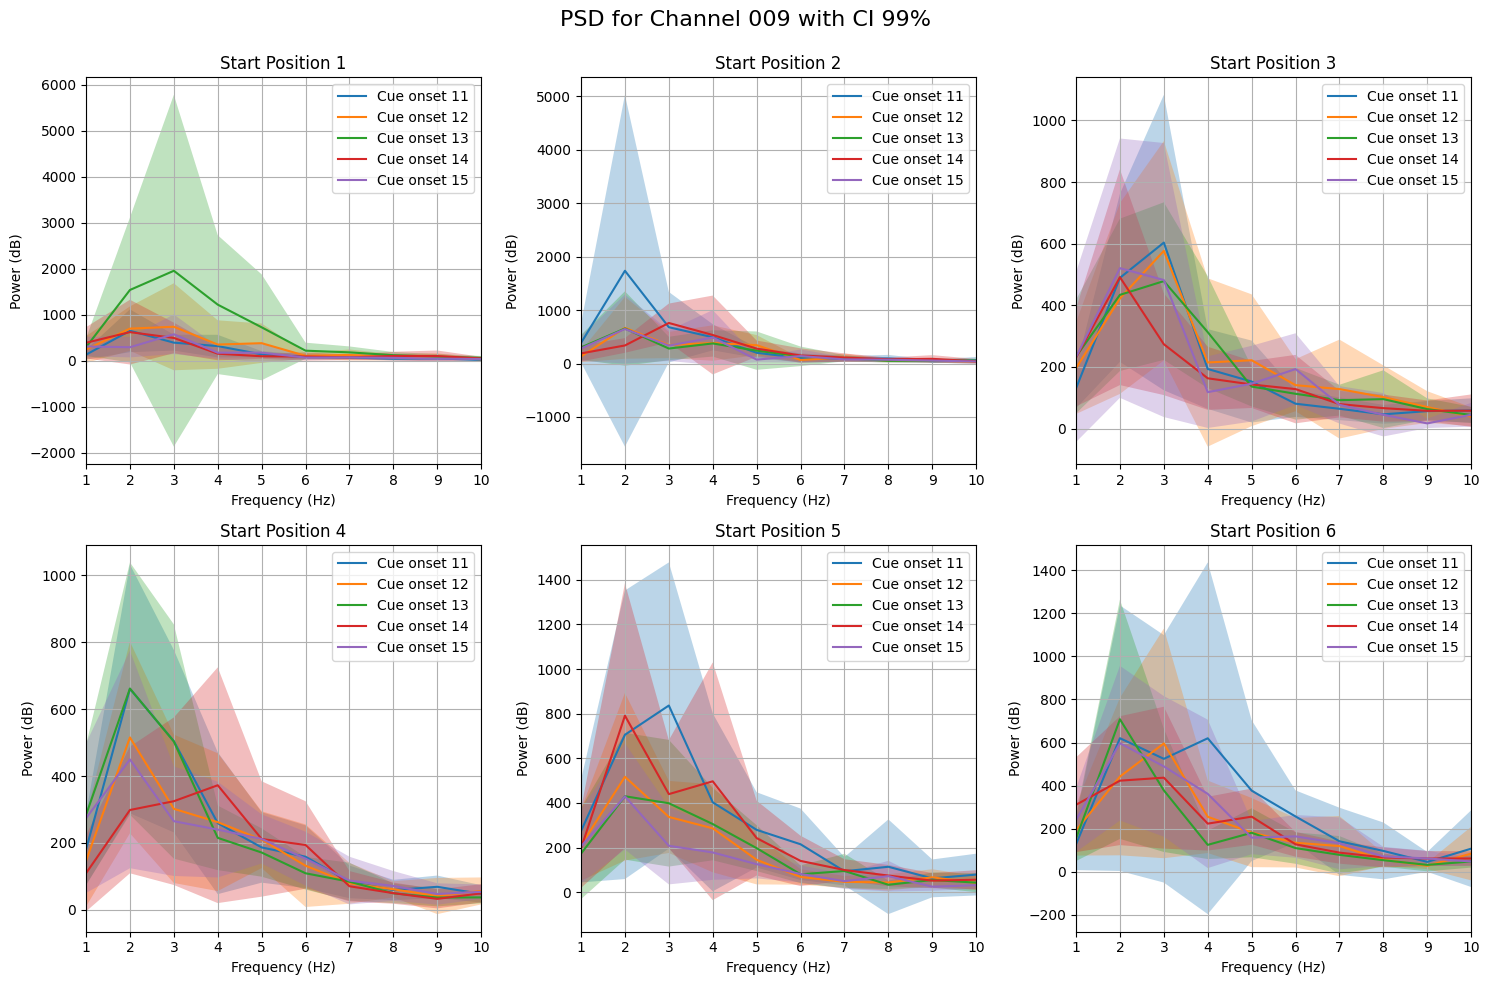

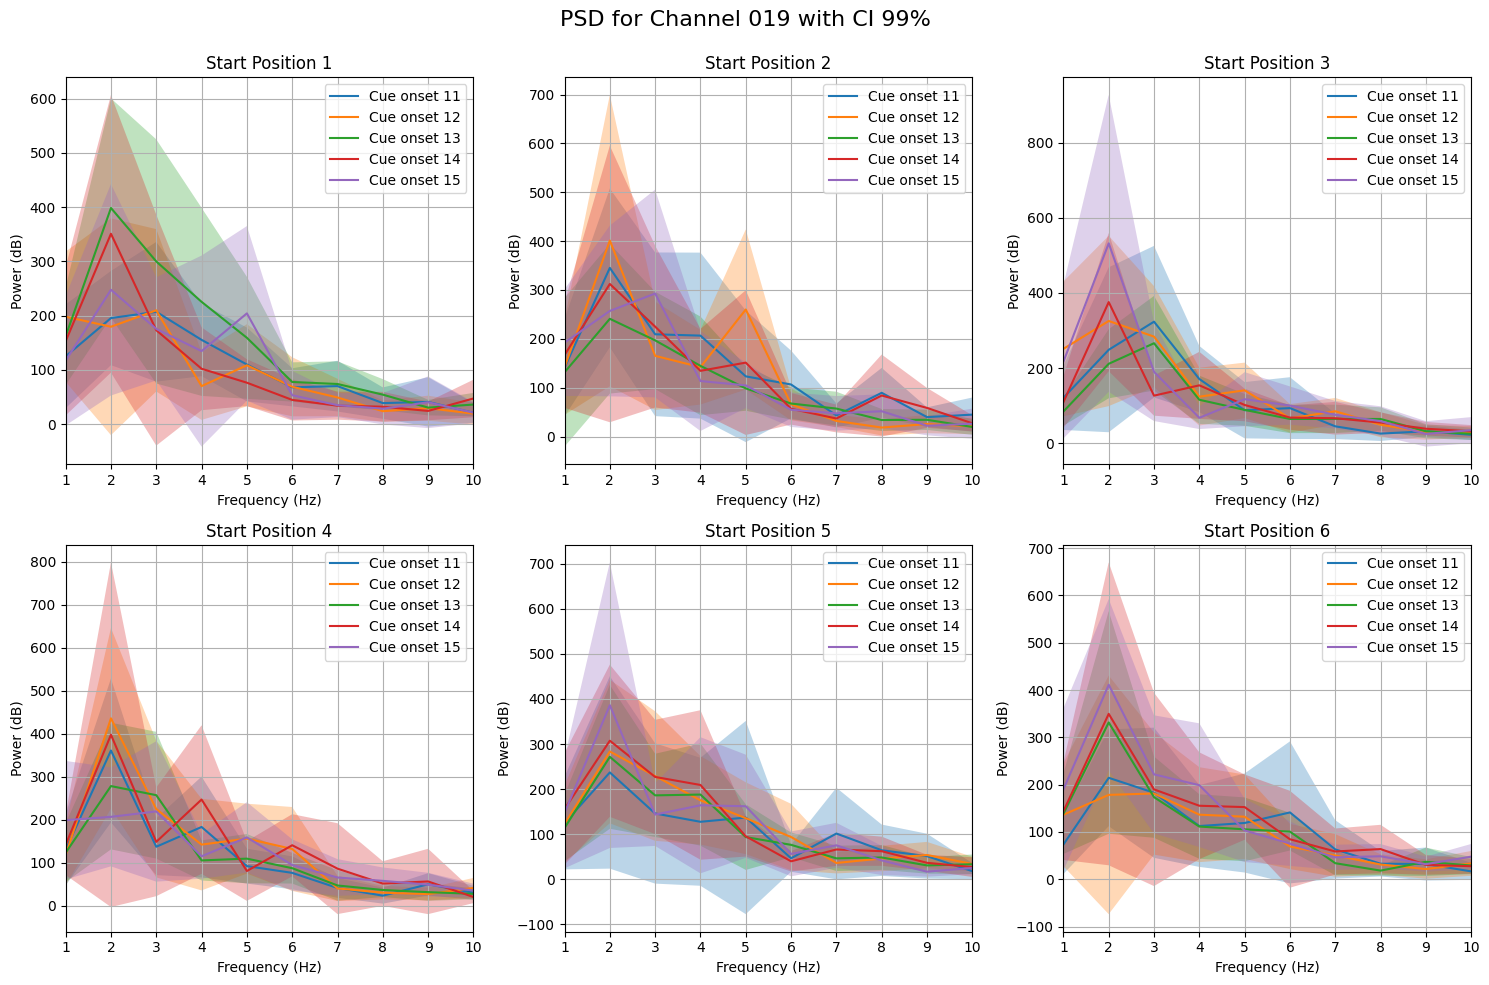

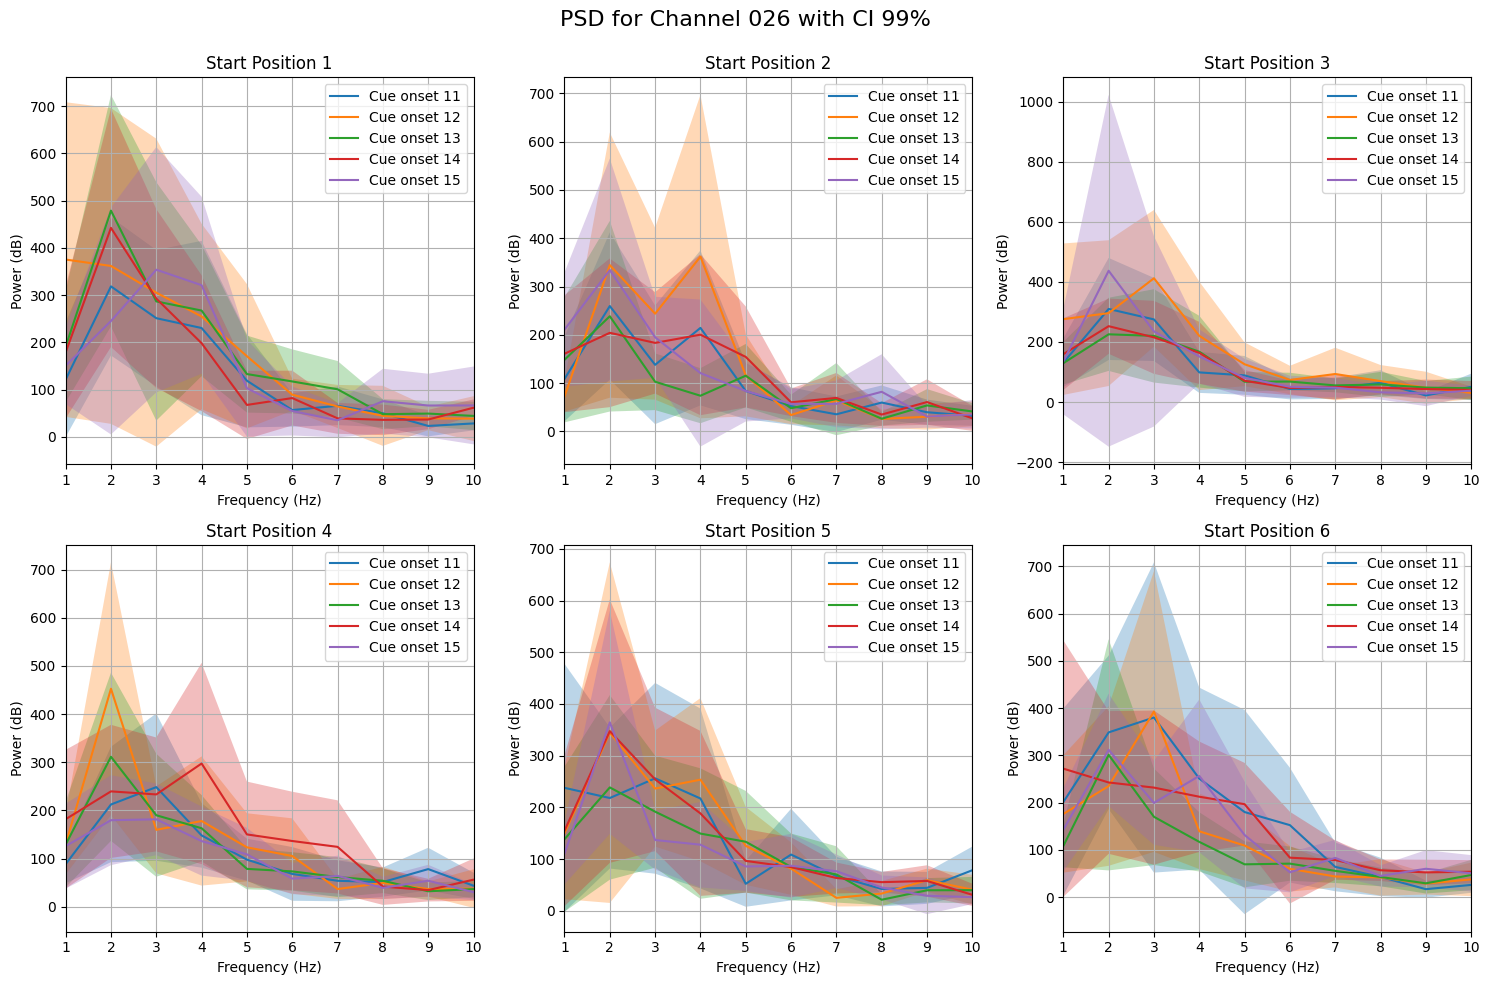

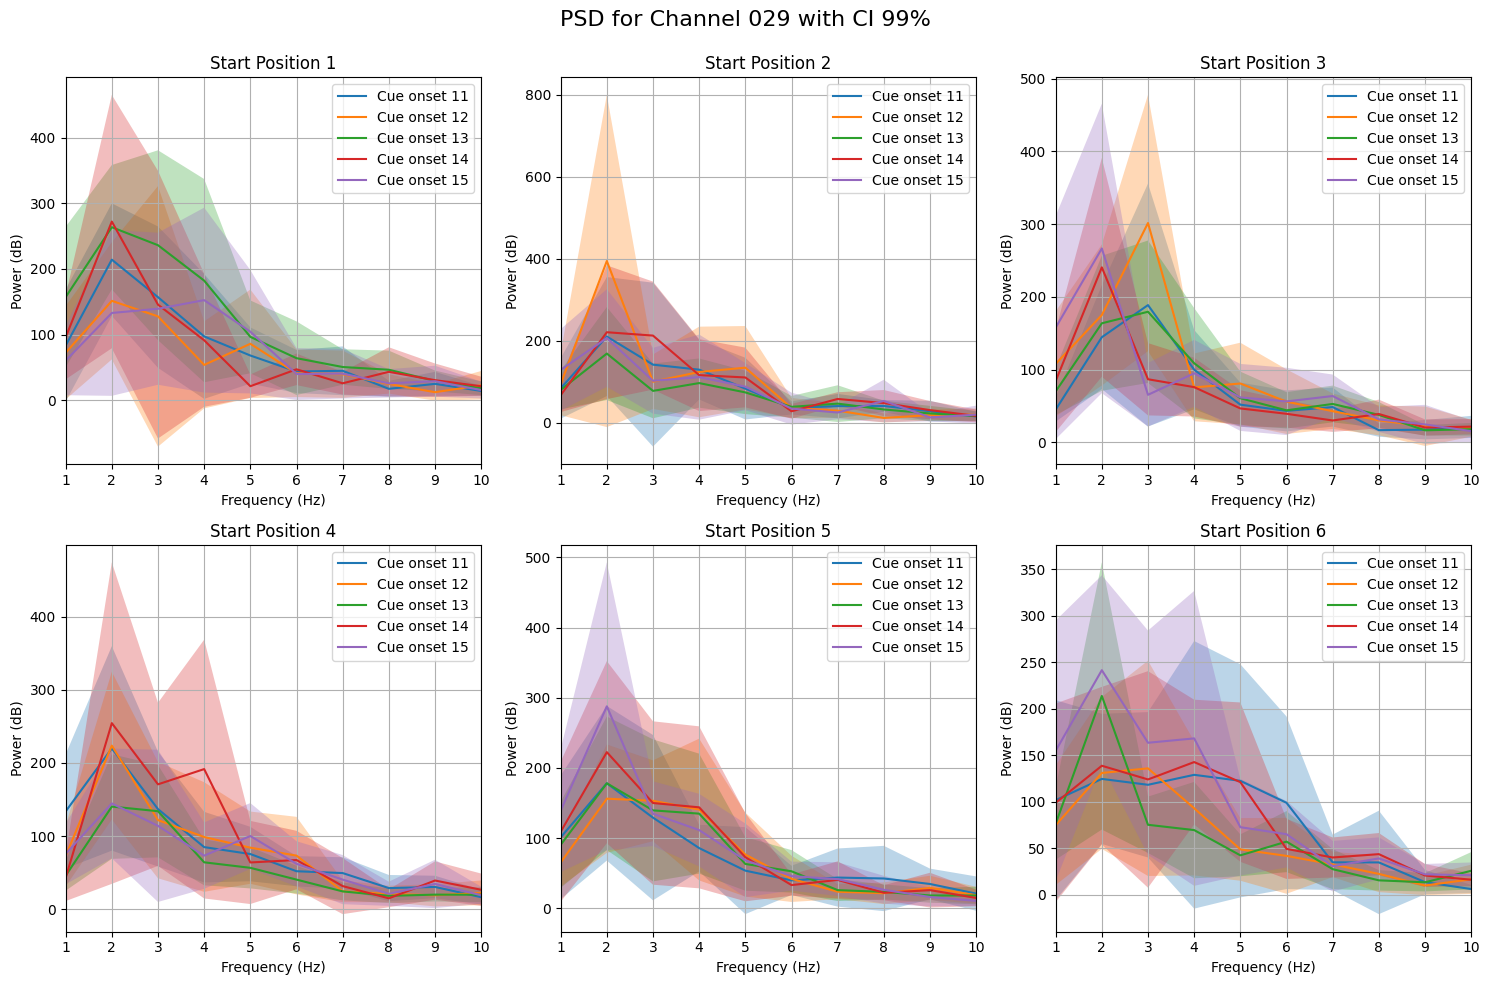

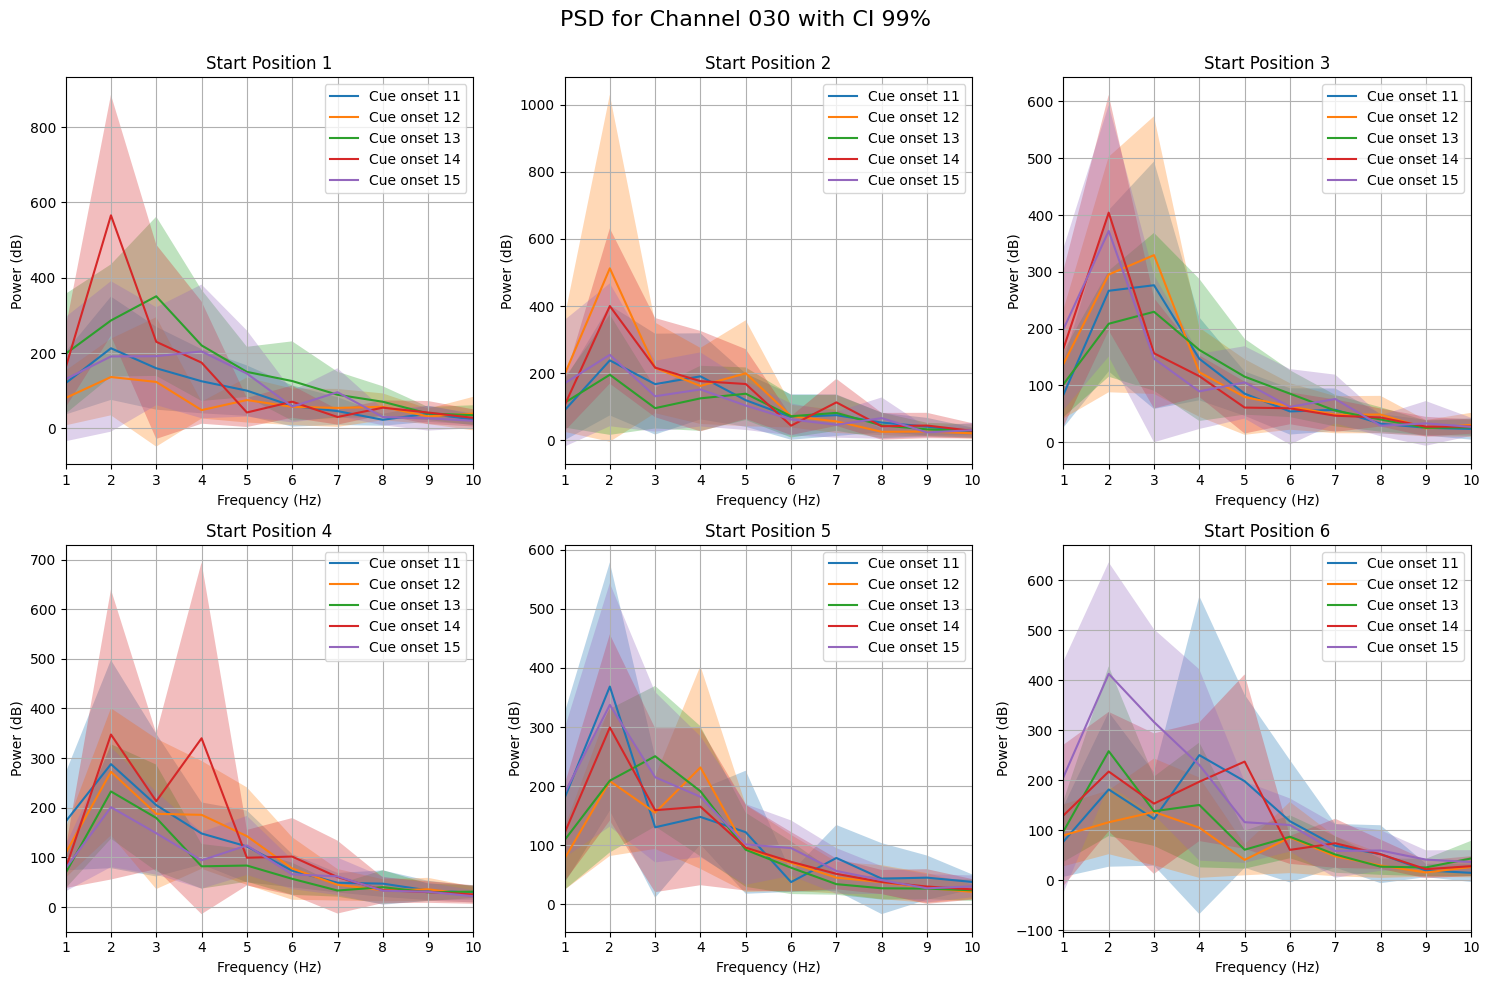

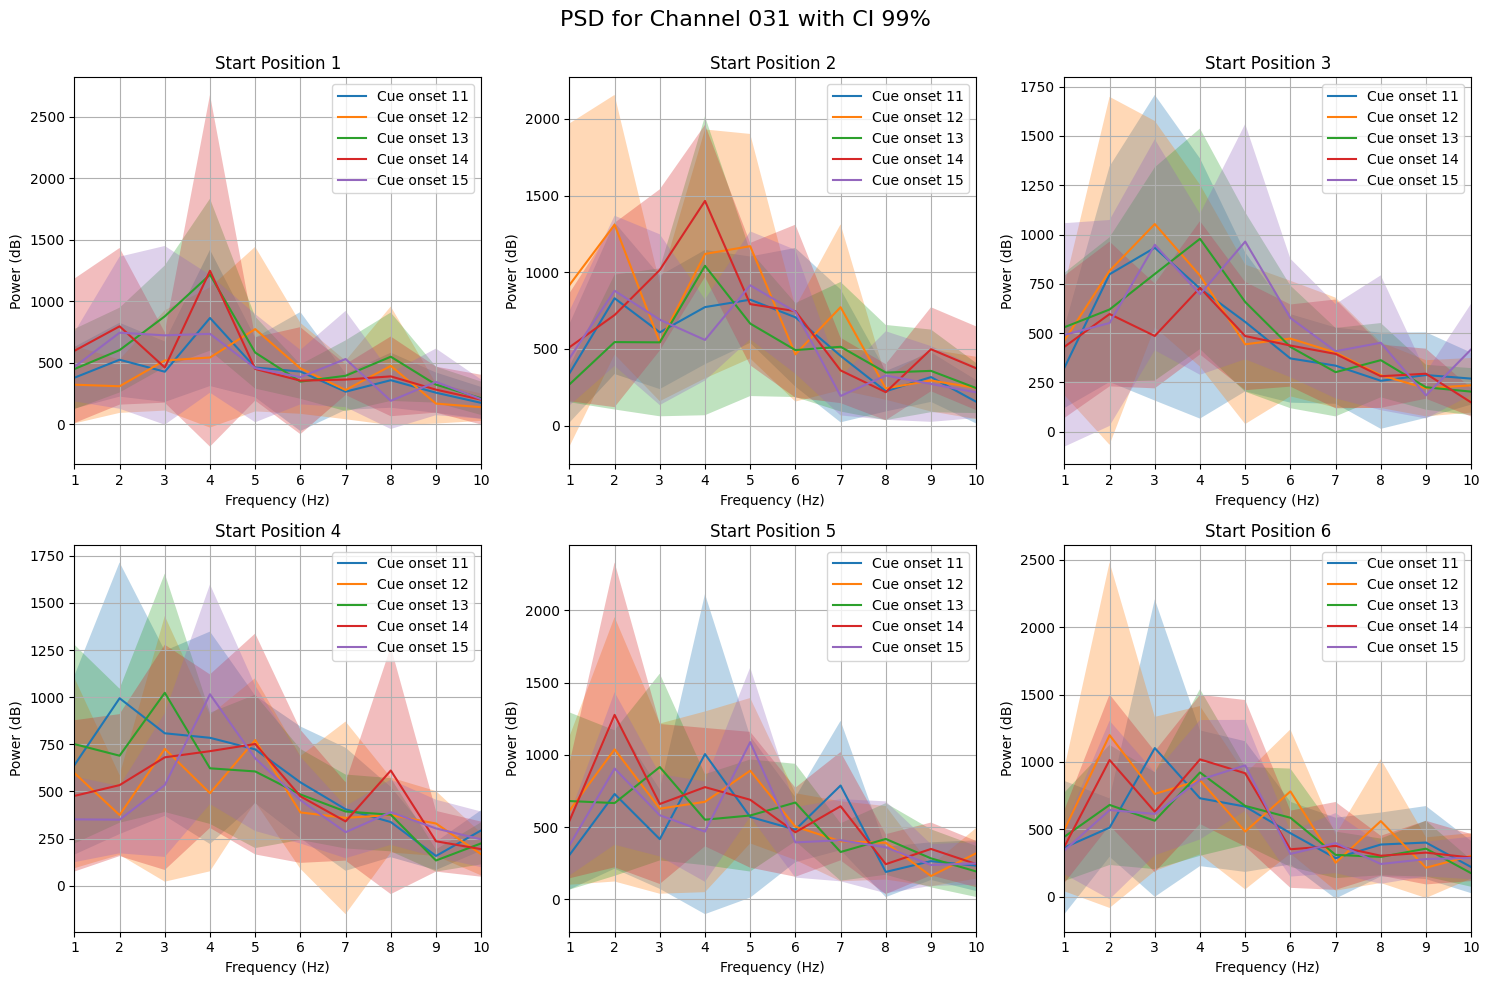

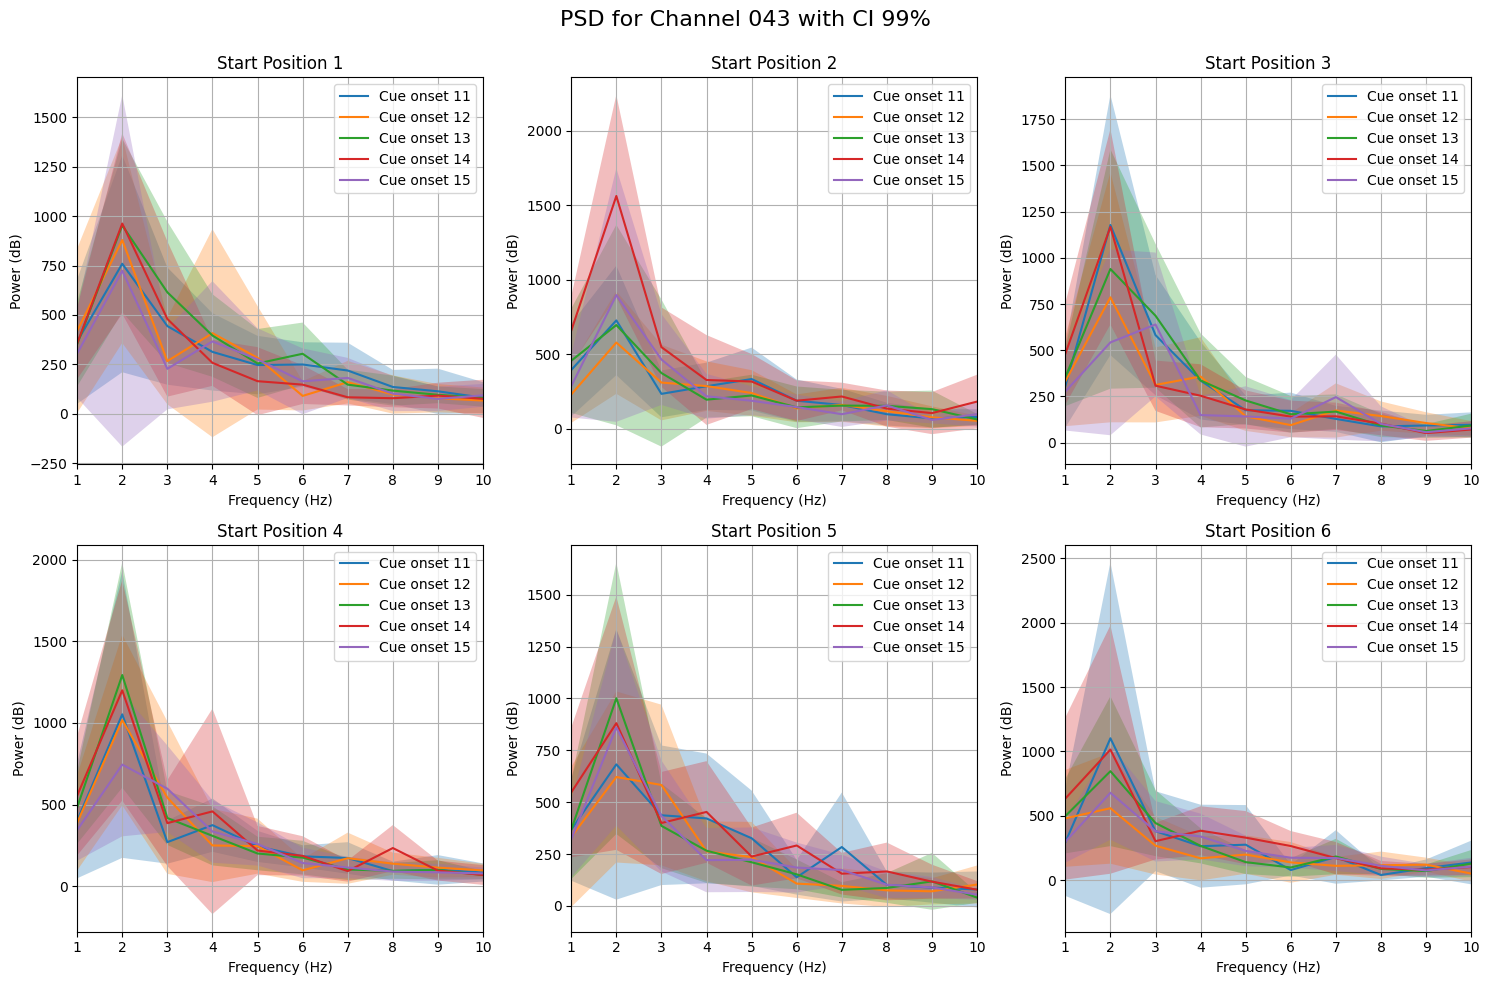

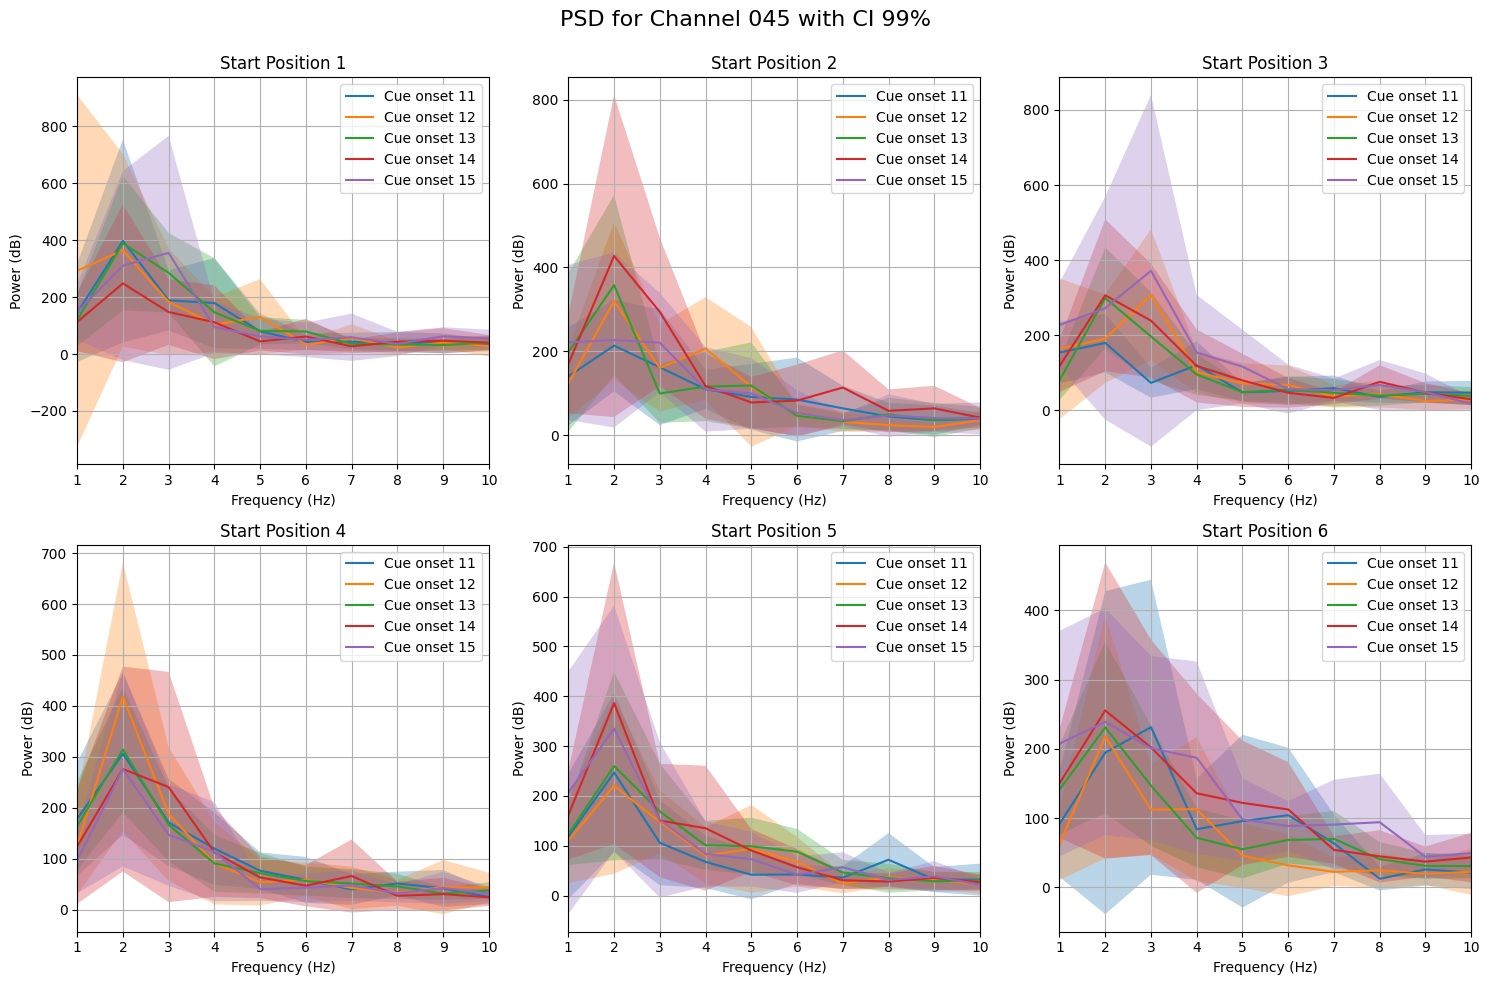

In [92]:
interesting_ch = {'20181102' : [9,19,26,29,30,31,43,45],
                  '20181105' : [19,23,29,30,43,45],
                  '20181101' : [19,21,23,29,30,35,43,45],
                  '20181031' : [19,26,29,30,35,43,45],
                  '20181026' : [19,29,30,35,45],
                  '20181022' : [9,17,26,29,43,45]
                  }
ch_indx = []

for i in interesting_ch[day]:
    # Convert i to a string and pad with zeros to match the format in channel_no
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

for ch in ch_indx:
    # Create a figure with 6 subplots, one for each position
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns of subplots
    axes = axes.flatten()  # Flatten axes for easy indexing

    for position in range(len(all_psd)):
        ax = axes[position]

        # Plot PSDs for all cue onsets for the current position
        for cue_onset in range(len(all_psd[position][ch])):
            mean_psd = np.mean(all_psd[position][ch][cue_onset], axis=0)
            sem_psd = sem(all_psd[position][ch][cue_onset], axis=0)
            ci = 2.576 * sem_psd  # 99% Confidence Interval
            # ci = 1.96 * sem_psd  # 95% Confidence Interval

            # Plot the mean PSD
            ax.plot(freq, mean_psd, label=f'Cue onset {cue_onset+11}')
            # Fill the confidence interval
            ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # Customize the subplot
        ax.set_title(f'Start Position {position+1}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
        ax.set_xlim([1,10])
        ax.legend(loc='upper right')
        ax.grid(True)

    # Adjust layout and show the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'PSD for Channel {channel_no[ch]} with CI 99%', fontsize=16)
    plt.show()

### Plotting Power of Theta by Channels

In [47]:
interesting_ch = [9,19,26,29,30,31,43,45]
ch_indx = []

for i in interesting_ch:
    # Convert i to a string and pad with zeros to match the format in channel_no
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

for ch in ch_indx:
    # Create a figure with 6 subplots, one for each position
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns of subplots
    axes = axes.flatten()  # Flatten axes for easy indexing

    for position in range(len(all_psd)):
        ax = axes[position]

        # Plot PSDs for all cue onsets for the current position
        for cue_onset in range(len(all_psd[position][ch])):
            

            # Plot the mean PSD
            ax.plot(freq, mean_psd, label=f'Cue onset {cue_onset+11}')
            # Fill the confidence interval
            ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # Customize the subplot
        ax.set_title(f'Start Position {position+1}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
        ax.set_xlim([1,10])
        ax.legend(loc='upper right')
        ax.grid(True)

    # Adjust layout and show the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'PSD for Channel {channel_no[ch]} with CI', fontsize=16)
    plt.show()

501

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

for position in range(len(all_psd_fft)):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    plot_count = 0
    for ch in ch_indx:
        combined_list = []
        
        for cue in range(len(all_psd_fft[position][ch])):
            fg = FOOOFGroup(verbose=False, max_n_peaks=3, peak_threshold=1)
            fg.fit(freq_fft, all_psd_fft[position][ch][cue], freq_range=[2, 15])
            para = fg.get_params('peak_params')
            peaks = np.concatenate([para.T[0], para.T[1], para.T[2]])
            combined_list.append(peaks)

        # Check the lengths of arrays in combined_list
        max_length = max(len(peaks) for peaks in combined_list)
        
        # Pad shorter arrays with NaNs to make them the same length
        padded_combined = np.array([np.pad(peaks, (0, max_length - len(peaks)), mode='constant', constant_values=np.nan) for peaks in combined_list])

        # Remove rows with NaN values
        padded_combined = padded_combined[~np.isnan(padded_combined).any(axis=1)]

        # Check the number of valid samples
        num_samples = padded_combined.shape[0]
        
        # If all entries were NaN and removed, skip clustering
        if num_samples == 0:
            print(f"No valid data to cluster for Channel {channel_no[ch]} at position {position+1}")
            plot_count += 1
            continue
        elif num_samples == 1:
            print(f"Only one sample for Channel {channel_no[ch]} at position {position+1}. Clustering skipped.")
            # Optionally: Use a single cluster for this case
            kmeans = KMeans(n_clusters=1, random_state=42)  # One cluster only
            kmeans.fit(padded_combined)
            cluster_centers = kmeans.cluster_centers_
        else:
            # Apply K-means clustering (change n_clusters as needed)
            kmeans = KMeans(n_clusters=min(2, num_samples), random_state=42)  # Adjust clusters based on available samples
            kmeans.fit(padded_combined)
            cluster_centers = kmeans.cluster_centers_

        # Plotting the peaks in strips
        sns.stripplot(data=combined_list, orient="v", ax=axes[plot_count])
        axes[plot_count].set_title(f'Channel {channel_no[ch]}')

        # Plotting cluster centers as horizontal lines
        for center in cluster_centers:
            axes[plot_count].axhline(y=center.mean(), color='r', linestyle='--')  # Horizontal line at the cluster center

        plot_count += 1

    x_labels = ['11', '12', '13', '14', '15', '16']
    del x_labels[position]
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(np.arange(0, 10, 2))  # Y-axis ticks from 0 to 10 with 2 intervals
    plt.ylim(2, 10)
    plt.suptitle(f'Peak Parameters Across Channels ({day}) Starting position 3{position + 1}', fontsize=16)  # Customize the title as needed

plt.tight_layout()
plt.show()


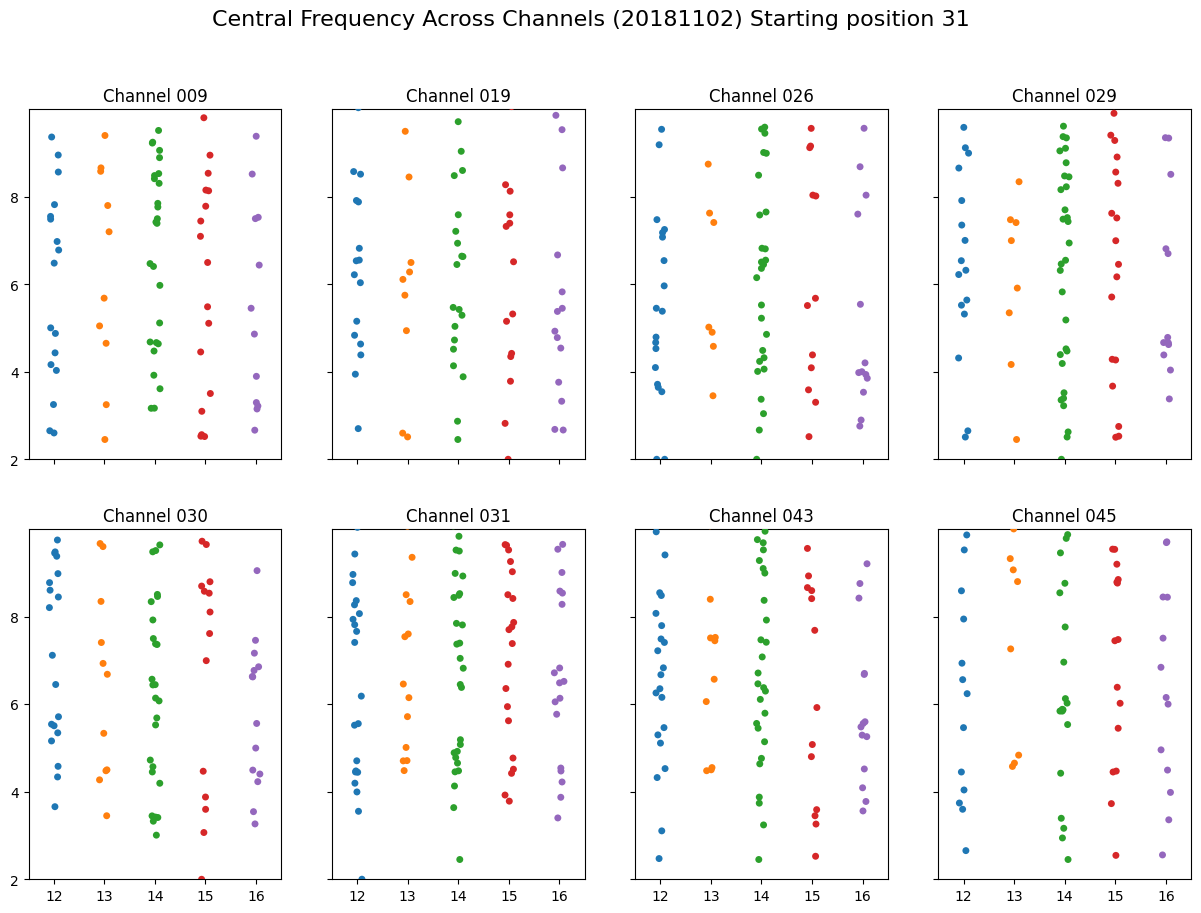

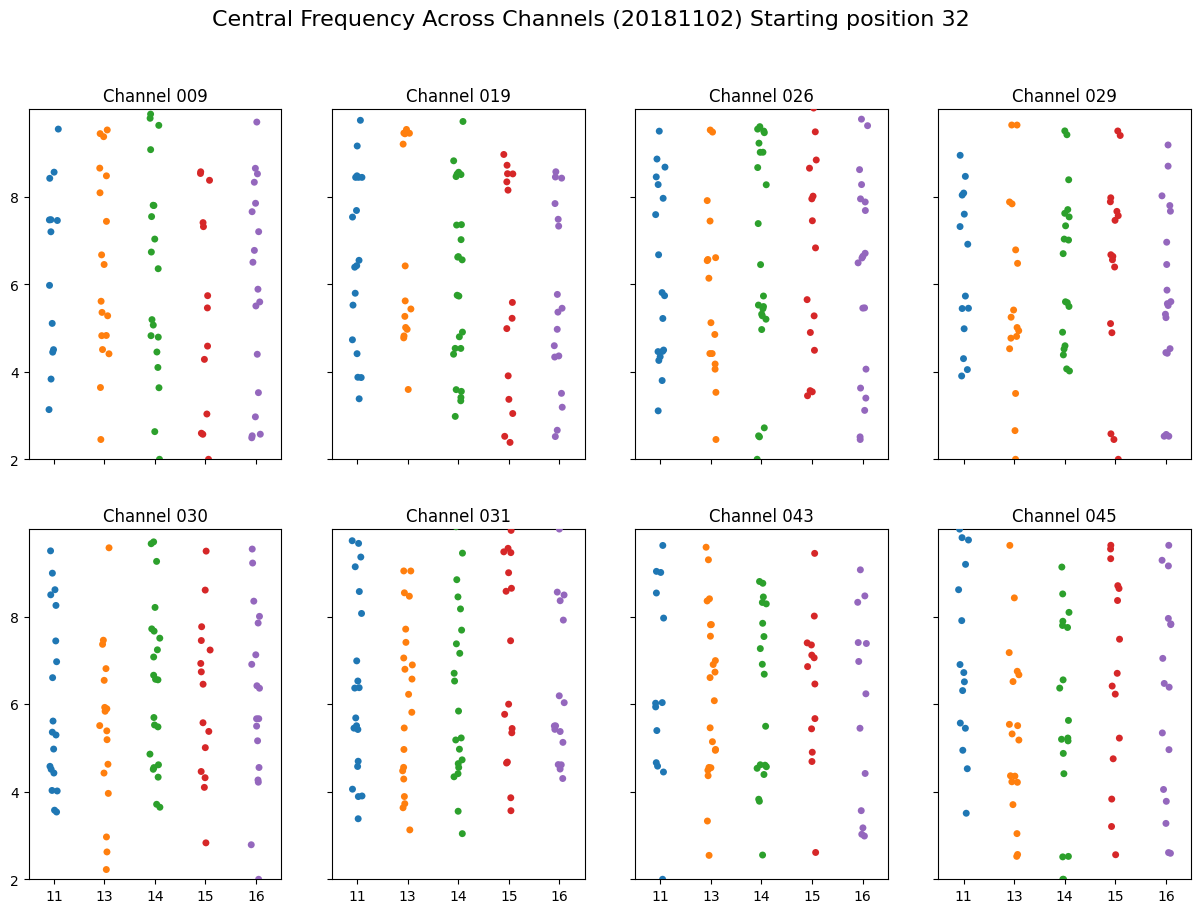

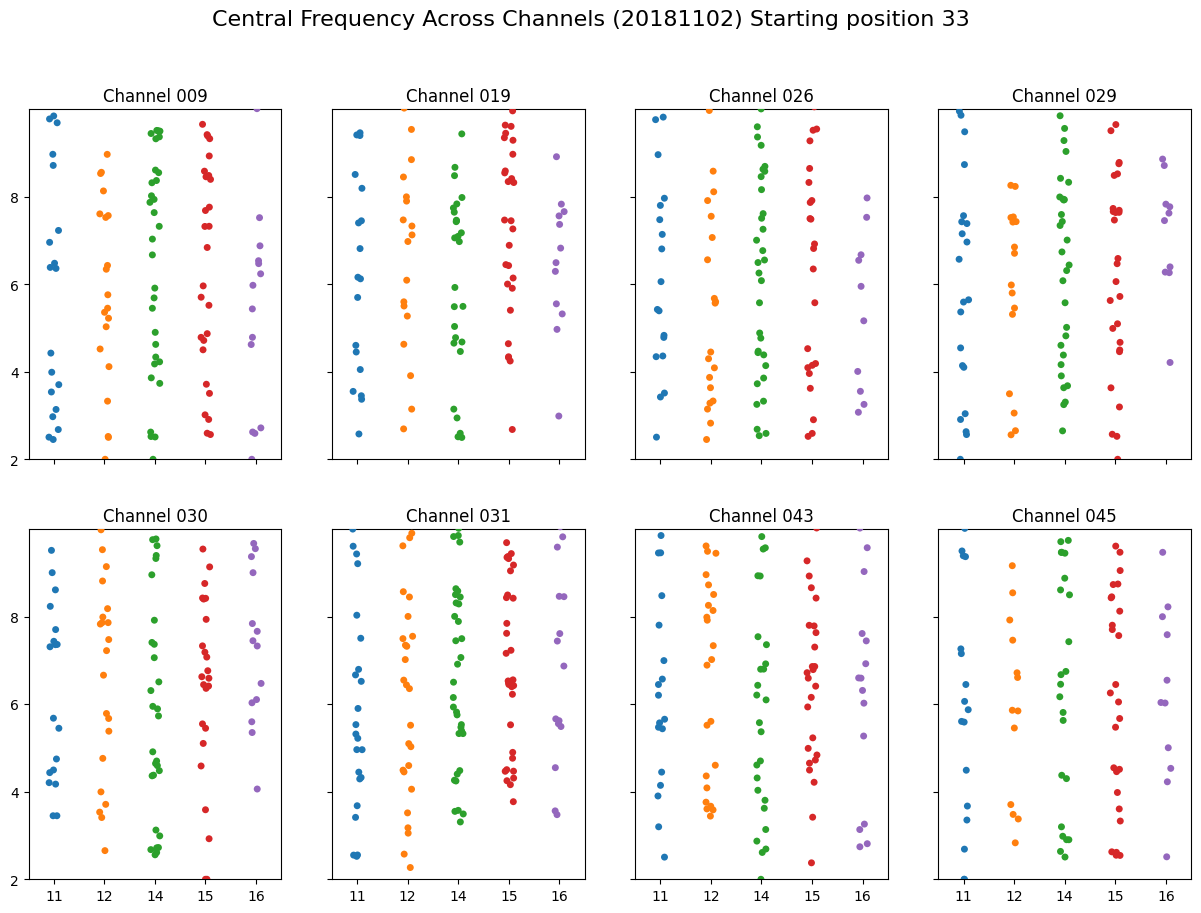

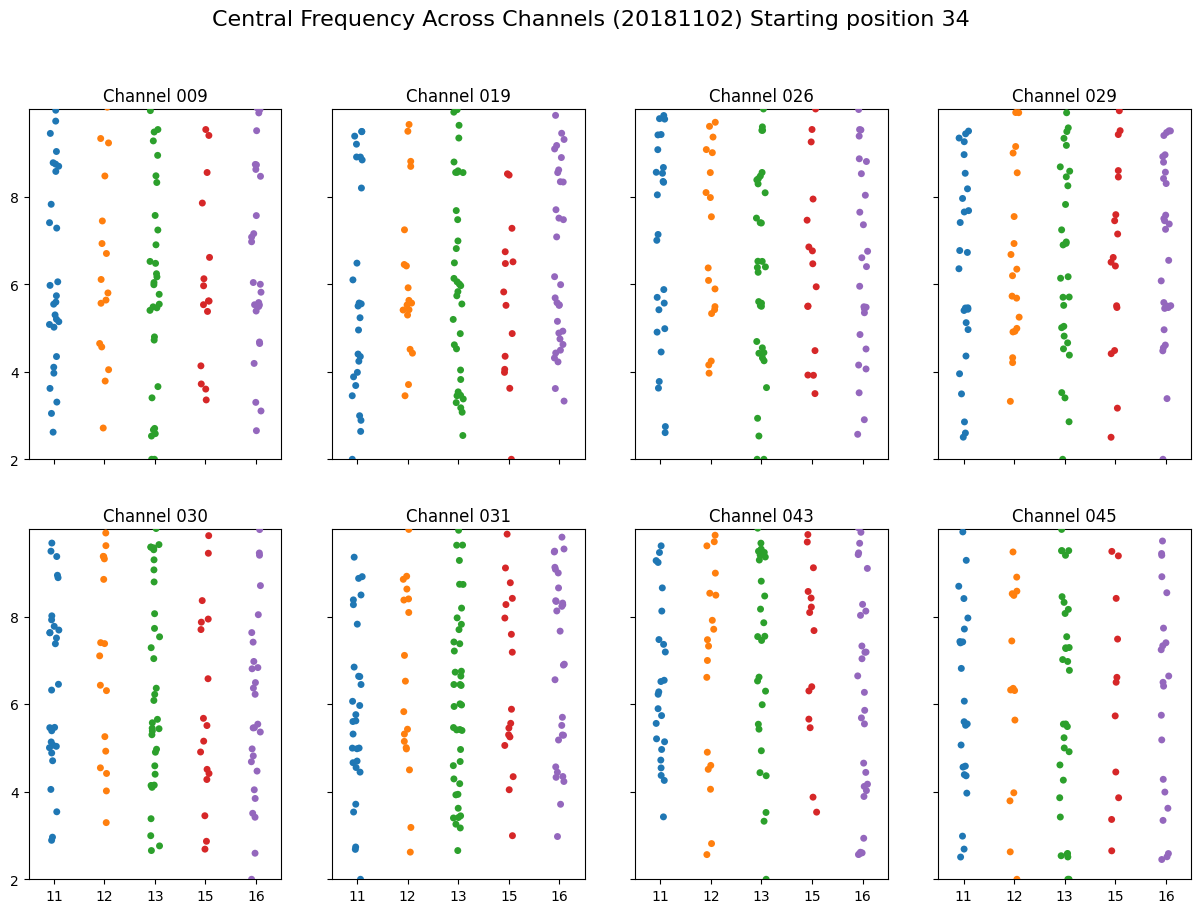

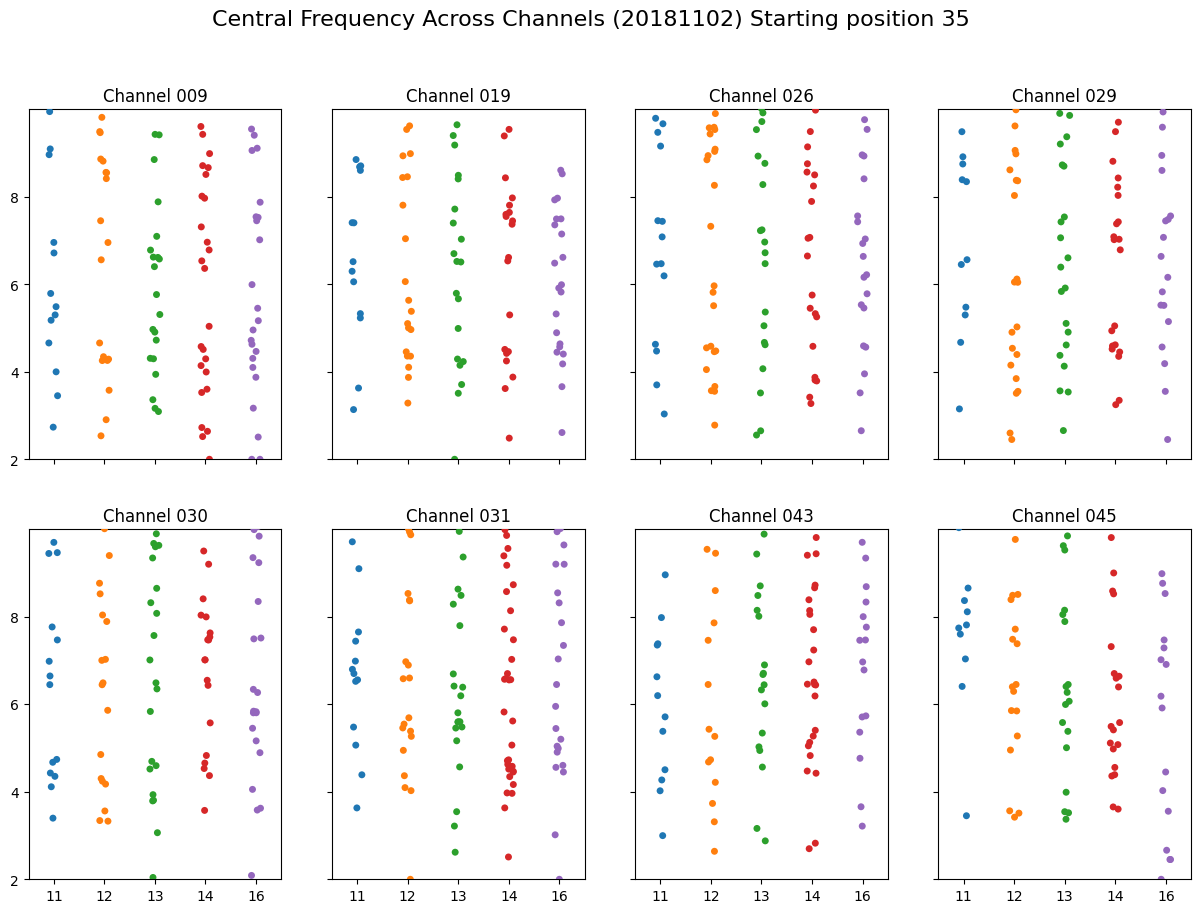

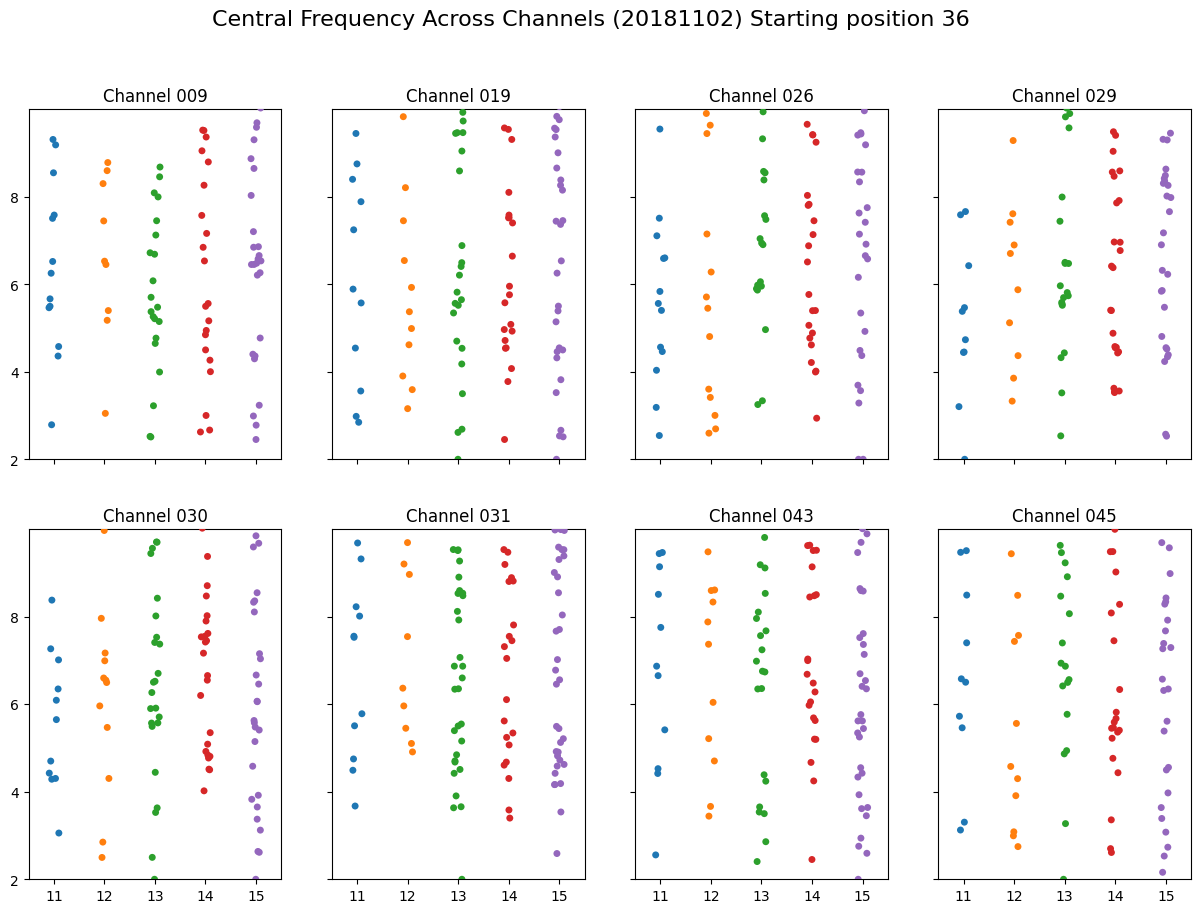

In [116]:
for position in range(len(all_psd_fft)):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    plot_count = 0
    for ch in ch_indx:
        combined_list = []
        
        for cue in range(len(all_psd_fft[position][ch])):
            # finding the peaks
            fg = FOOOFGroup(verbose=False, max_n_peaks=3, peak_threshold=1)
            fg.fit(freq_fft, all_psd_fft[position][ch][cue],freq_range=[2,15])
            para = fg.get_params('peak_params').T[0]
            combined_list.append(para)

        # plotting the peaks in strips
        sns.stripplot(data=combined_list, orient="v", ax = axes[plot_count])
        axes[plot_count].set_title(f'Channel {channel_no[ch]}')
        plot_count+=1

    x_labels = ['11','12','13','14','15','16']
    del x_labels[position]
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(np.arange(0, 10, 2))  # X-axis ticks from 0 to 10 with 0.5 intervals
    plt.ylim(2,10)
    plt.suptitle(f'Central Frequency Across Channels ({day}) Starting position 3{position+1}', fontsize=16)  # Customize the title as needed

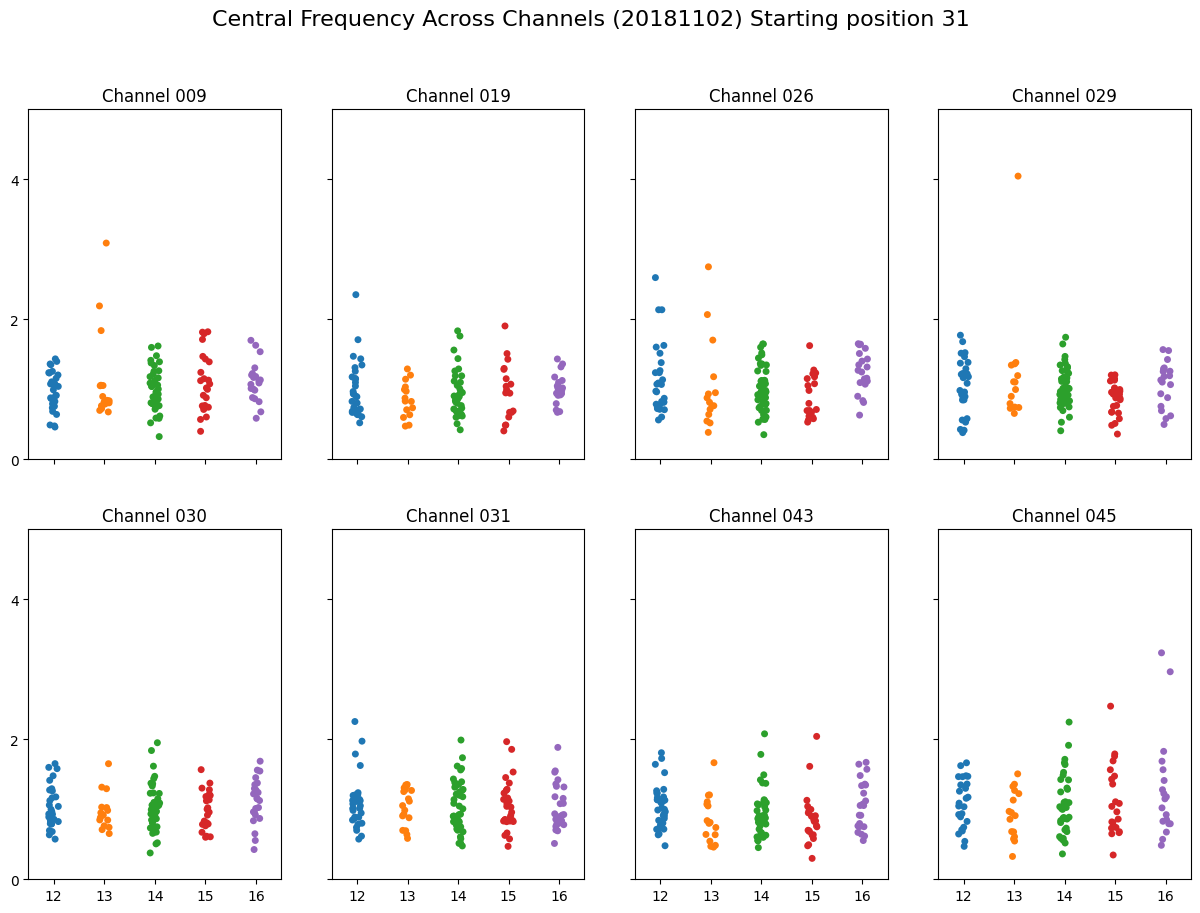

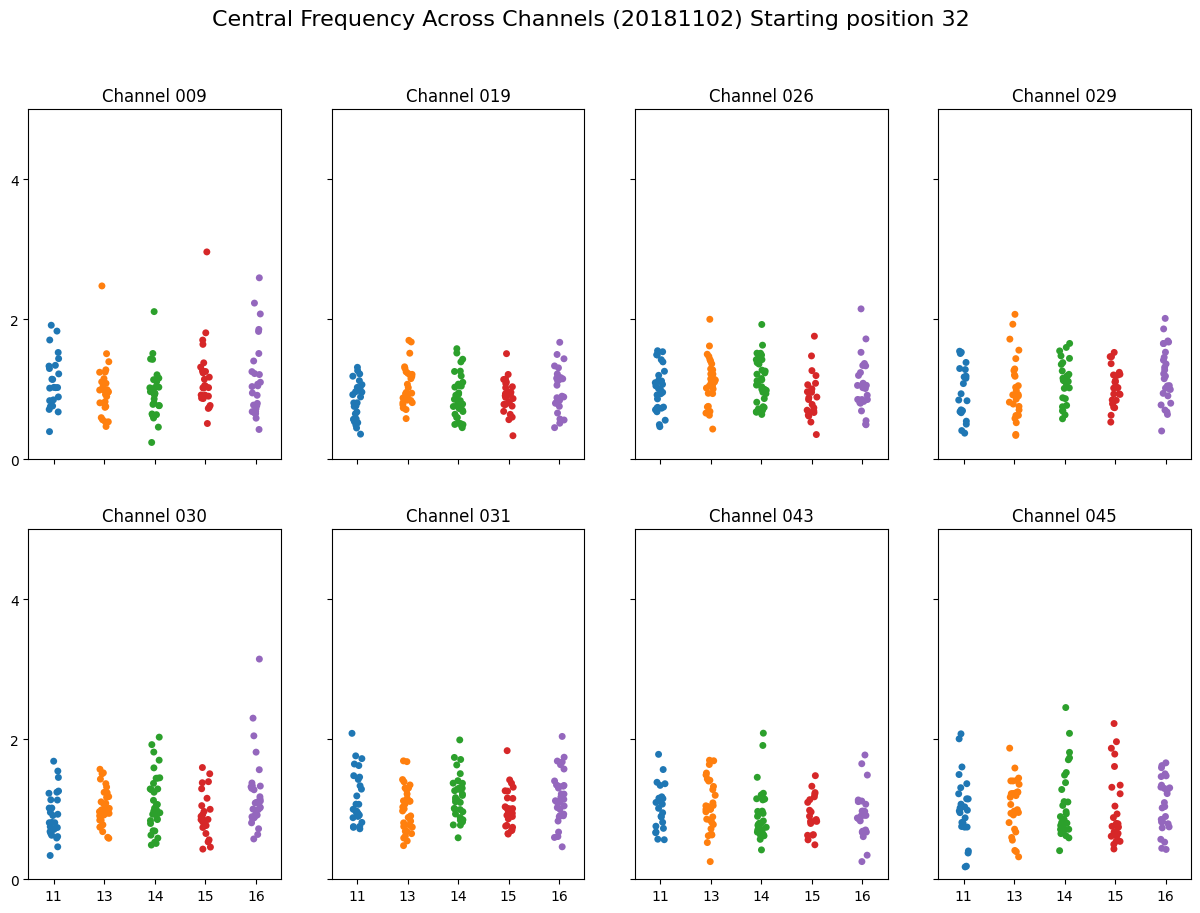

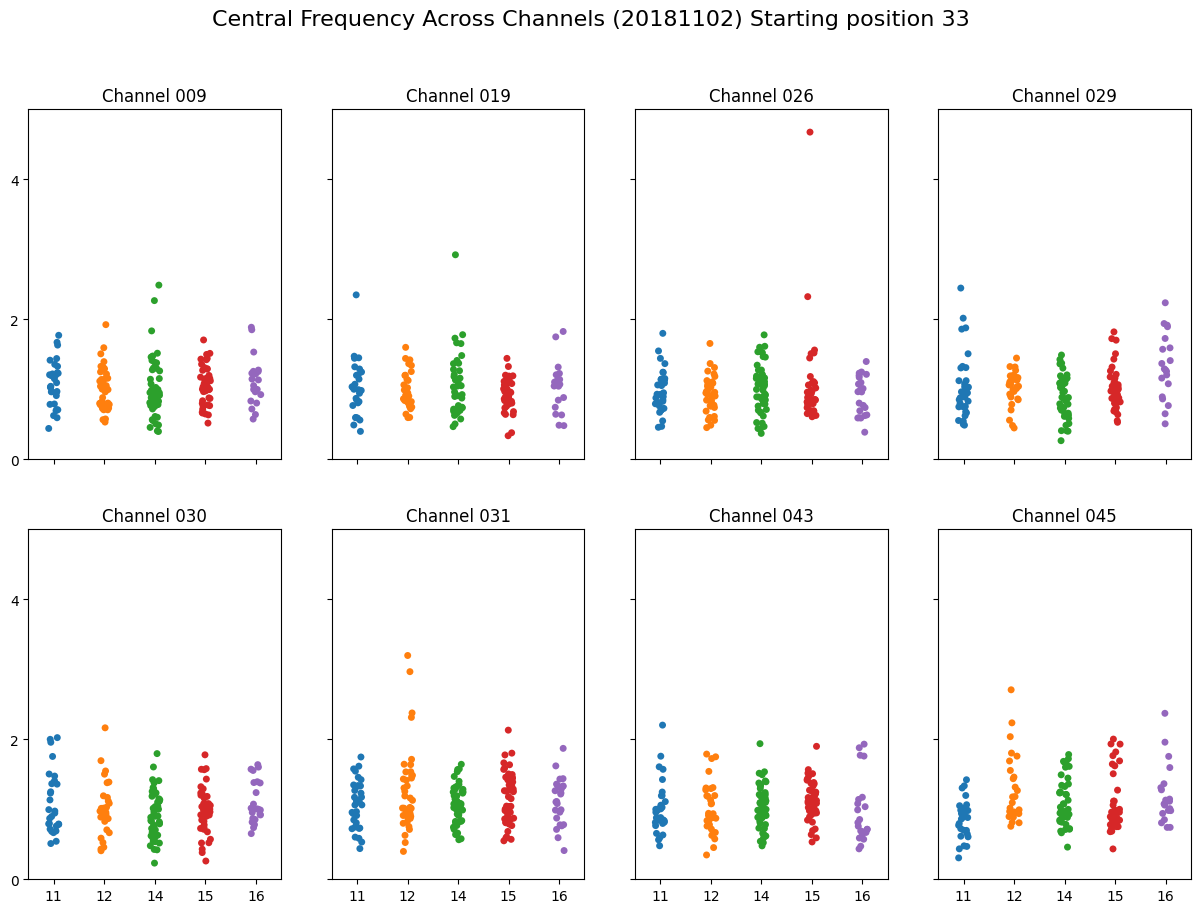

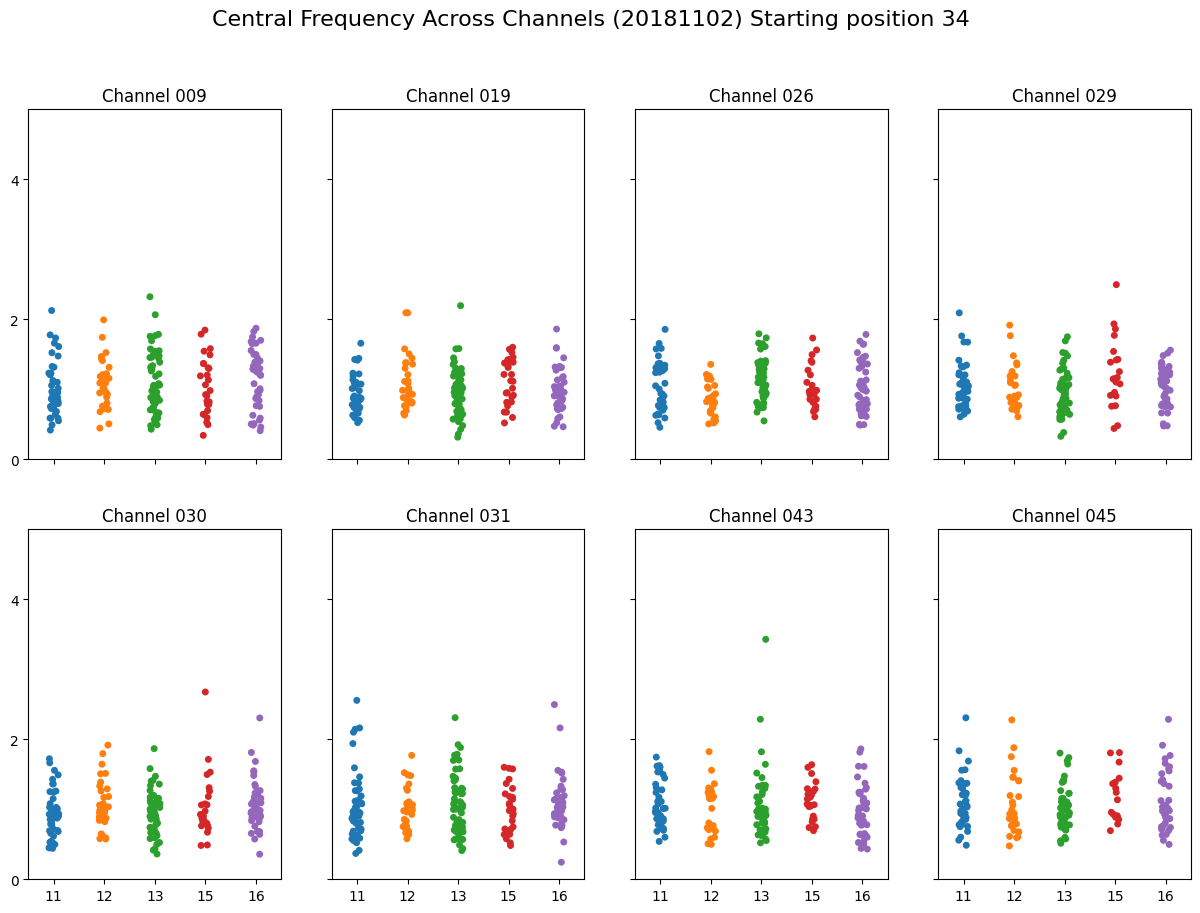

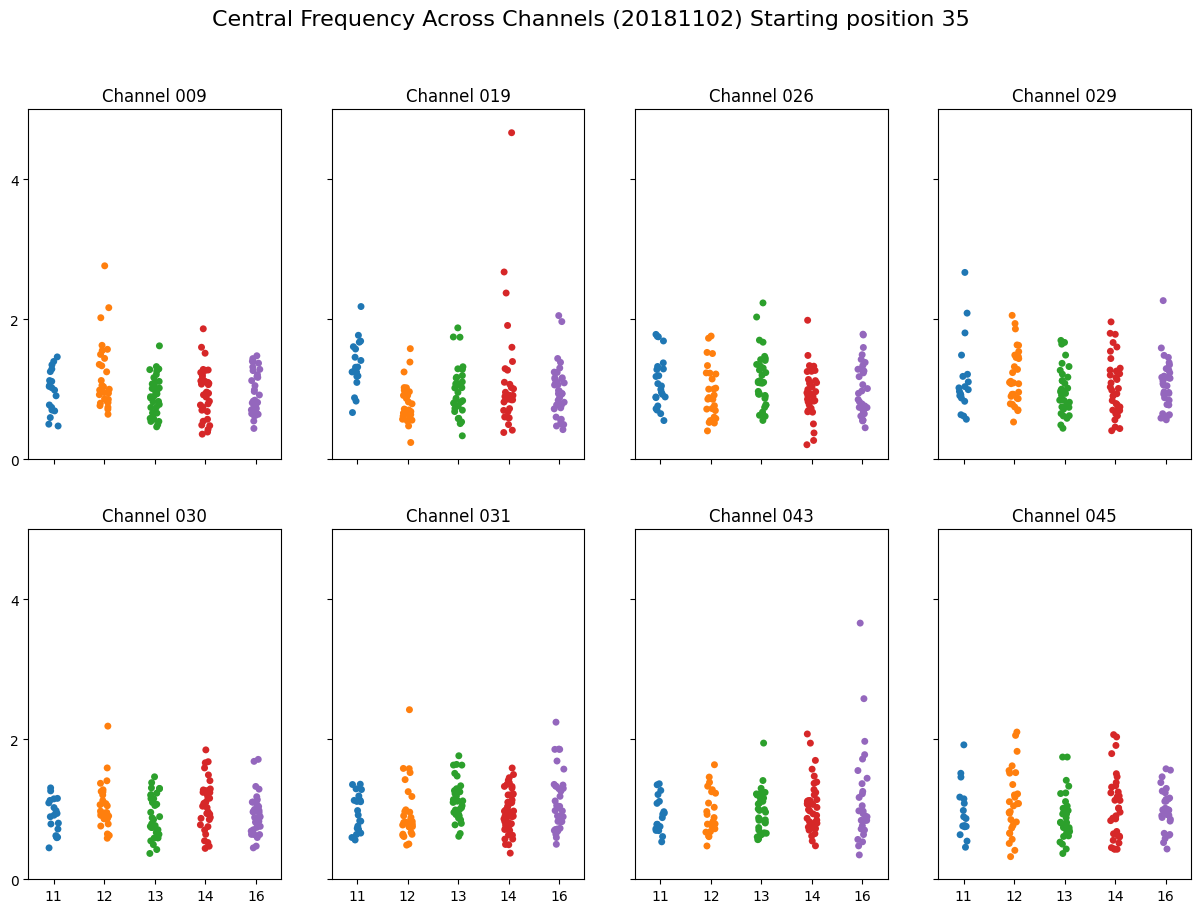

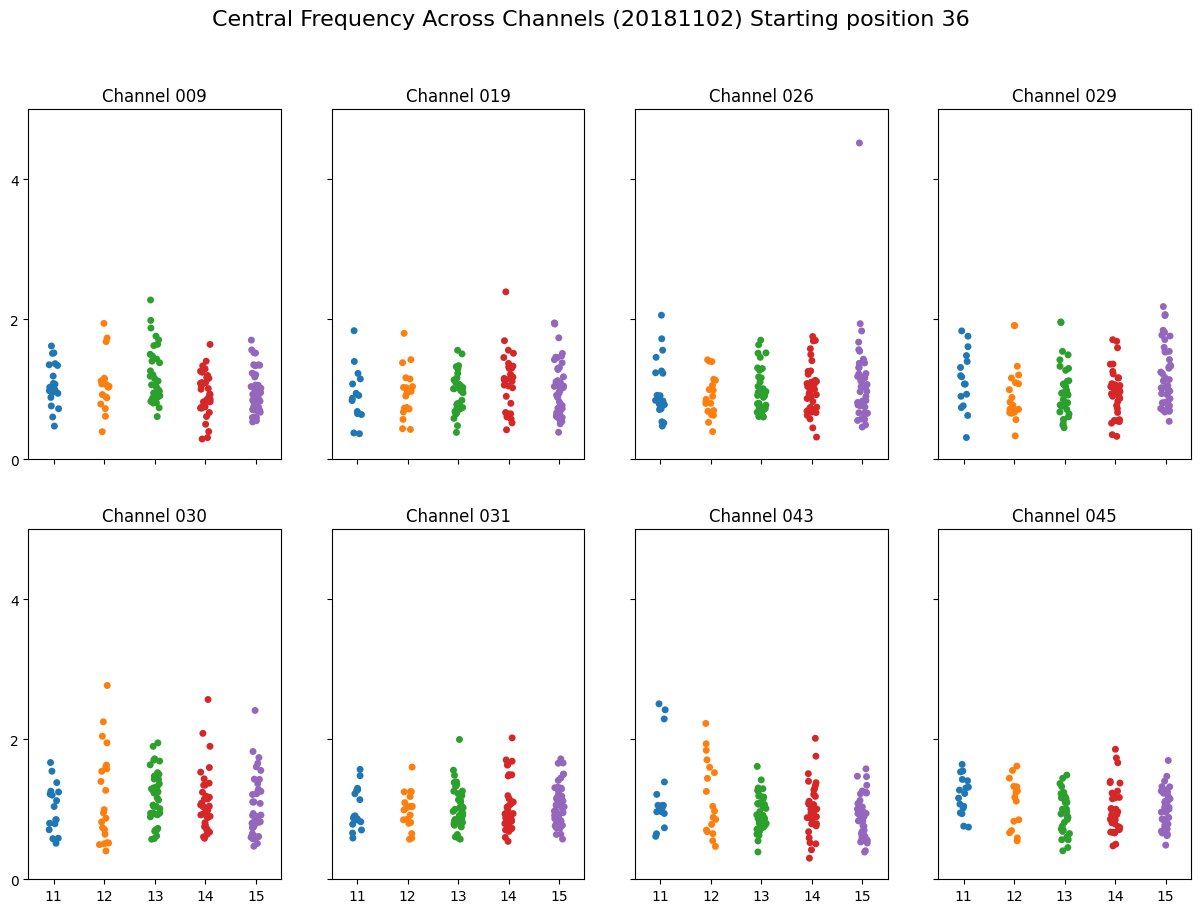

In [120]:
all_psd_fft_test = np.transpose(all_psd_fft, (1,0,2))

for ch in ch_indx:
    fig, axes = plt.subplots(2, len(ch_indx)//2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    params = []

    for position in range(len(all_psd_fft_test[ch])):
        for cue in range(len(all_psd_fft_test[ch][position])):
            fg = FOOOFGroup(verbose=False, max_n_peaks=3, peak_threshold=1)
            fg.fit(freq_fft, all_psd_fft[position][ch][cue],freq_range=[2,15])
            para = fg.get_params('peak_params').T[1]
                         
for position in range(len(all_psd_fft)):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    plot_count = 0

    for ch in ch_indx:
        combined_list = []
        
        for cue in range(len(all_psd_fft[position][ch])):
            # finding the peaks
            fg = FOOOFGroup(verbose=False, max_n_peaks=3, peak_threshold=1)
            fg.fit(freq_fft, all_psd_fft[position][ch][cue],freq_range=[2,15])
            para = fg.get_params('peak_params').T[1]
            combined_list.append(para)

        # plotting the peaks in strips
        sns.stripplot(data=combined_list, orient="v", ax = axes[plot_count])
        axes[plot_count].set_title(f'Channel {channel_no[ch]}')
        plot_count+=1

    x_labels = ['11','12','13','14','15','16']
    del x_labels[position]
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(np.arange(0, 10, 2))  # X-axis ticks from 0 to 10 with 0.5 intervals
    plt.ylim(0,3)
    plt.suptitle(f'Central Frequency Across Channels ({day}) Starting position 3{position+1}', fontsize=16)  # Customize the title as needed


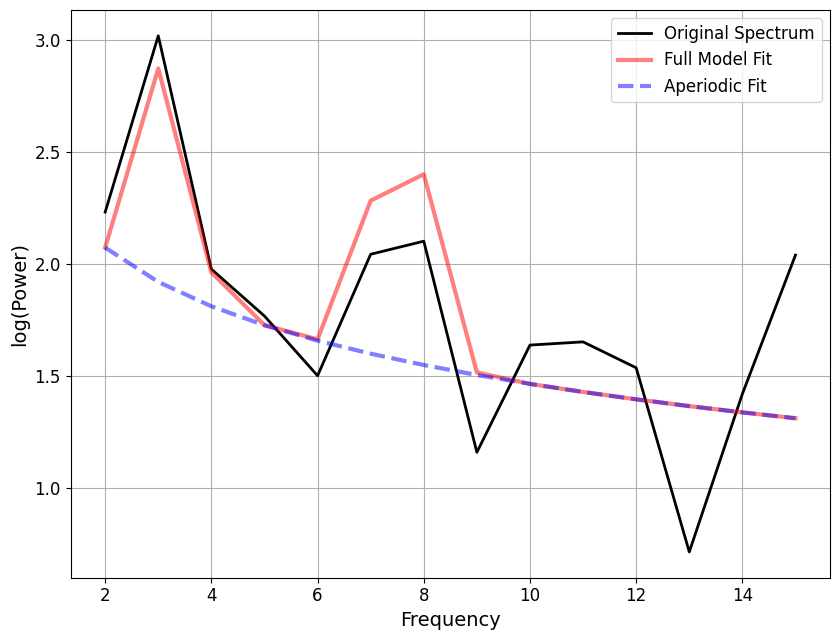

In [34]:
fm = fg.get_fooof(ind=6, regenerate=True)
fm.plot()

Running FOOOFGroup across 57 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


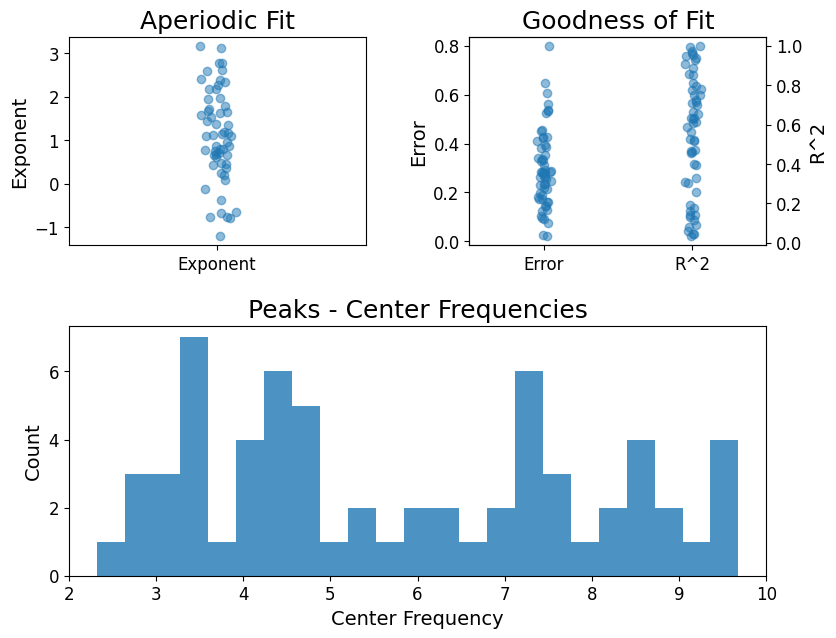

In [108]:
temp = []
for i in all_psd[0][0]:
    for j in i:
        temp.append(j)
temp = np.array(temp)
fg = FOOOFGroup(peak_threshold=1.76)
fg.fit(freq, temp, [2,10])

fg.plot()